##### Exploratory Data Analysis

#### Steps
    Data Ingestion
    Data Validation
    Data Statistics
    Data Visualization
    Data Interpretation & Analysis

##### Data Ingestion - Start
    Load csv data file from data folder : pan_shop_and_sales.csv
    

In [ ]:
import os
import pandas as pd

path = "./data/pan_shop_and_sales.csv"
pan_shops_df = pd.read_csv(path, na_values=["NA", ""], keep_default_na=False)
pan_shops_df.columns
cat = pan_shops_df.select_dtypes(include="object").columns
con = pan_shops_df.select_dtypes(include=["int64", "float64"]).columns
cat, con
pan_shops_df.head(1)

##### Data Ingestion - End

##### Data Validation - Start
    Check duplicate records
    Check null values



In [ ]:
# Check Duplicate Records

duplicate_records = pan_shops_df.duplicated().sum()
if duplicate_records <= 0:
    print("Duplicate Records does not exist")

# Check Null records
null_count = pan_shops_df.isna().sum().sum()
if null_count <= 0:
    print("Null Records does not exist")

##### Data Validation - End

##### Data Statistics - Start

In [ ]:
# Categorical Columns
cat

In [ ]:
# Continuous Columns
con

In [ ]:
# Describe Categorical Columns
pan_shops_df[cat].describe()

In [ ]:
# Describe Continuous Columns
pan_shops_df[con].describe()

In [58]:
# Correlation between Continuous columns
corr = pan_shops_df[con].corr()
corr
# Profit with other continuous columns
corr = (
    pan_shops_df.corr(numeric_only=True)["Profit"]
    .drop("Profit")
    .sort_values(axis=0)
    .reset_index()
)
corr = corr.rename(
    columns={"index": "Categorical_Cols", "Profit": "Profit_Correlation"}
).sort_values(by=["Profit_Correlation"], ascending=False)
corr = corr[corr["Profit_Correlation"] >= 0.4]
num_imp_cols_list = corr["Categorical_Cols"].to_list()
num_imp_cols_list

# Important Continuous Columns
# Sold, UnitPrice, Quantity

['Sold', 'UnitPrice', 'Quantity']

##### Finding important categorical variables
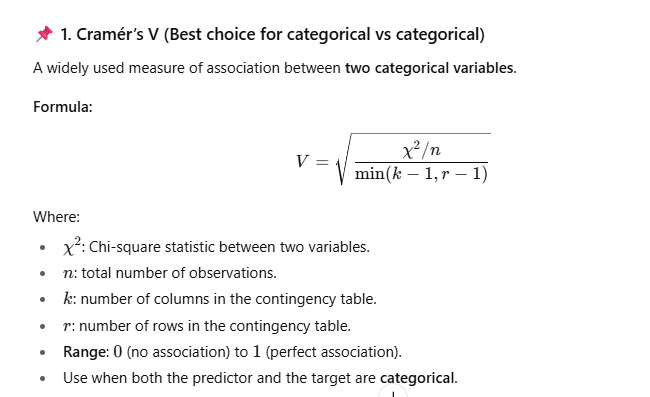

In [62]:
import numpy as np
from scipy.stats import chi2_contingency


# Cramér's V function
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt((chi2 / n) / (min(k - 1, r - 1)))


pan_shops_df["Profit_Category"] = pd.qcut(
    pan_shops_df["Profit"], q=4, labels=["Low", "Medium", "High", "Very High"]
)

cat_cols = pan_shops_df.select_dtypes(include=["object", "category"]).columns
cat_cols

target = "Profit_Category"

# Cramers V calculation
cramers_results = {}
for col in cat_cols:
    if col != target:
        try:
            cramers_results[col] = cramers_v(pan_shops_df[col], pan_shops_df[target])
        except Exception as ex:
            cramers_results[col] = np.nan


cramers_df = pd.DataFrame.from_dict(
    cramers_results, orient="index", columns=["Cramers_V"]
).reset_index()
cramers_df = (
    cramers_df[cramers_df["Cramers_V"] >= 0.2]
    .sort_values(by=["Cramers_V"], ascending=False)
    .reset_index()
)
cat_imp_cols_list = cramers_df["index"].to_list()

pan_shops_df[cat_imp_cols_list].nunique().sort_values(ascending=False)

Time        4856
Owner        300
Location     300
Name         228
dtype: int64

In [64]:
# Merge Categorical and Continuous Columns
print(cat_imp_cols_list)
print(num_imp_cols_list)
imp_cols_list = num_imp_cols_list + cat_imp_cols_list
imp_cols_list

# Remove high cardinality columns

['Time', 'Name', 'Owner', 'Location']
['Sold', 'UnitPrice', 'Quantity']


['Sold', 'UnitPrice', 'Quantity', 'Time', 'Name', 'Owner', 'Location']

##### ANOVA - Analysis of Variance

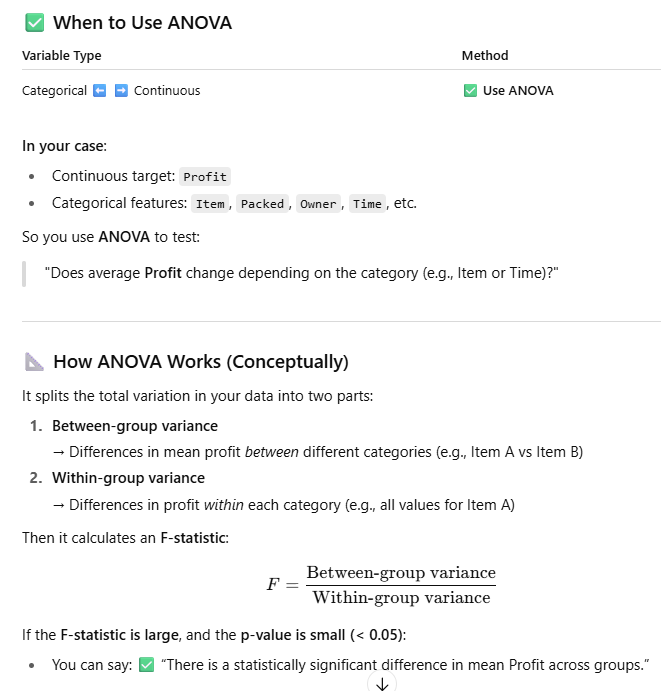

In [63]:
# Anova

from scipy.stats import f_oneway

anova_scores = {}
for col in cat_cols:
    if col != "Profit_Category":
        try:
            groups = [
                group["Profit"].dropna().values
                for name, group in pan_shops_df.groupby(col)
            ]
            if len(groups) > 1:
                f_stat, p_val = f_oneway(*groups)
                anova_scores[col] = p_val  # You could store f_stat as well
        except:
            anova_scores[col] = np.nan

anova_df = pd.DataFrame.from_dict(anova_scores, orient="index", columns=["ANOVA_p"])
anova_df = anova_df[anova_df["ANOVA_p"] < 0.05].sort_values(by="ANOVA_p")
anova_imp_cols = anova_df.index.to_list()
anova_imp_cols

['Time', 'Name', 'Date']

In [72]:
pan_shops_df[cat_imp_cols_list].nunique().sort_values(ascending=False)
# Since unique values are high Target Encoding is to be used if low then one hot encoding
from sklearn.model_selection import KFold


def target_encode(train_series, target_series, n_splits=5):
    # Initialize encoded feature with zeros
    encoded_feature = pd.Series(index=train_series.index, dtype=float)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for train_idx, val_idx in kf.split(train_series):
        # Calculate mean target per category on train fold
        means = (
            target_series.iloc[train_idx].groupby(train_series.iloc[train_idx]).mean()
        )
        # Map means to validation fold
        encoded_feature.iloc[val_idx] = train_series.iloc[val_idx].map(means)

    # For any missing mappings (new categories), fill with global mean
    encoded_feature.fillna(target_series.mean(), inplace=True)

    return encoded_feature


# Apply target encoding to each categorical column
for col in cat_imp_cols_list:
    pan_shops_df[col + "_target_enc"] = target_encode(
        pan_shops_df[col], pan_shops_df[target]
    )

print(pan_shops_df[[col + "_target_enc" for col in cat_imp_cols_list]].head())

   Time_target_enc  Name_target_enc  Owner_target_enc  Location_target_enc
0       480.350000       170.676829        192.553500           192.553500
1       301.590000       224.271750        234.456471           234.456471
2       202.197049       224.271750        234.456471           234.456471
3       102.710000       198.909744        189.442381           189.442381
4       202.197049       198.909744        189.442381           189.442381


In [ ]:
# !where python
# pip show scipy in Terminal

##### Data Statistics - End

##### Complete Program to extract Features and Target


In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

path = "./data/pan_shop_and_sales.csv"
pan_shops_df = pd.read_csv(path, na_values=["NA", ""], keep_default_na=False)
pan_shops_df.columns
cat = pan_shops_df.select_dtypes(include="object").columns
con = pan_shops_df.select_dtypes(include=["int64", "float64"]).columns


# Target(Profit) with other continuous columns
corr = (
    pan_shops_df[pan_shops_df["Profit"] >= 0.4]
    .corr(numeric_only=True)["Profit"]
    .drop("Profit")
    .sort_values(axis=0)
    .reset_index()
)

num_imp_cols_list = corr["index"].to_list()
print(f"Continuous Imp Cols: {num_imp_cols_list}")


# Cramér's V function
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt((chi2 / n) / (min(k - 1, r - 1)))


pan_shops_df["Profit_Category"] = pd.qcut(
    pan_shops_df["Profit"], q=4, labels=["Low", "Medium", "High", "Very High"]
)

cat_cols = pan_shops_df.select_dtypes(include=["object", "category"]).columns


target = "Profit_Category"

# Cramers V calculation
cramers_results = {}
for col in cat_cols:
    if col != target:
        try:
            cramers_results[col] = cramers_v(pan_shops_df[col], pan_shops_df[target])
        except Exception as ex:
            cramers_results[col] = np.nan


cramers_df = pd.DataFrame.from_dict(
    cramers_results, orient="index", columns=["Cramers_V"]
).reset_index()
cramers_df = (
    cramers_df[cramers_df["Cramers_V"] >= 0.2]
    .sort_values(by=["Cramers_V"], ascending=False)
    .reset_index()
)
cat_imp_cols_list = cramers_df["index"].to_list()
print(f"Categorical Imp Cols: {cat_imp_cols_list}")

features_list = list(set(num_imp_cols_list + cat_imp_cols_list))
target = "Profit"

print(f"Features: {features_list}, Target: {target}")


def target_encode(train_series, target_series, n_splits=5):
    # Initialize encoded feature with zeros
    encoded_feature = pd.Series(index=train_series.index, dtype=float)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for train_idx, val_idx in kf.split(train_series):
        # Calculate mean target per category on train fold
        means = (
            target_series.iloc[train_idx].groupby(train_series.iloc[train_idx]).mean()
        )
        # Map means to validation fold
        encoded_feature.iloc[val_idx] = train_series.iloc[val_idx].map(means)

    # For any missing mappings (new categories), fill with global mean
    encoded_feature.fillna(target_series.mean(), inplace=True)

    return encoded_feature


# Apply target encoding to each categorical column
for col in cat_imp_cols_list:
    pan_shops_df[col + "_target_enc"] = target_encode(
        pan_shops_df[col], pan_shops_df[target]
    )

print(pan_shops_df[[col + "_target_enc" for col in cat_imp_cols_list]].head())

# Select continuous features
cont_features = ["Size", "Rent", "Quantity", "UnitPrice", "Sold"]

# Select encoded categorical features
encoded_cat_features = [
    col + "_target_enc" for col in ["Time", "Name", "Owner", "Location"]
]

# Final feature list
final_features = cont_features + encoded_cat_features

# Prepare X and y
X = pan_shops_df[final_features]
y = pan_shops_df["Profit"]

print(X.head())
print(y.head())


# Features and target
X = pan_shops_df[cont_features + encoded_cat_features]
y = pan_shops_df["Profit"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Model
model = RandomForestRegressor(random_state=42, n_estimators=100)

# Train
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)  # by default, squared=True (MSE)
rmse = np.sqrt(mse)  # take square root to get RMSE
print(f"RMSE: {rmse:.4f}")
print(f"R^2 Score: {r2_score(y_test, y_pred):.4f}")

Continuous Imp Cols: ['Size', 'Rent', 'Quantity', 'UnitPrice', 'Sold']
Categorical Imp Cols: ['Time', 'Name', 'Owner', 'Location']
Features: ['Name', 'Time', 'Location', 'Size', 'Rent', 'Quantity', 'Owner', 'UnitPrice', 'Sold'], Target: Profit
   Time_target_enc  Name_target_enc  Owner_target_enc  Location_target_enc
0       480.350000       170.676829        192.553500           192.553500
1       301.590000       224.271750        234.456471           234.456471
2       202.197049       224.271750        234.456471           234.456471
3       102.710000       198.909744        189.442381           189.442381
4       202.197049       198.909744        189.442381           189.442381
   Size   Rent  Quantity  UnitPrice  Sold  Time_target_enc  Name_target_enc  \
0    74  11914        31      48.55    30       480.350000       170.676829   
1    74  11914        76      33.71    66       301.590000       224.271750   
2    74  11914        31      34.50     6       202.197049       224.